# Projet SER

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import kaggle
import keras

from IPython.display import Audio
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import  LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

### 1. RAVDESS

In [2]:
Ravdess = "data_SIAKE/audio_speech_actors_01-24"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        
        if len(part) >= 3:
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + '/' + dir + '/' + file)

In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...


### 2. Crema DataFrame

In [5]:
Crema = "data_SIAKE/AudioWAV"

In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/'+  file)
    # storing file emotions
    part=file.split('_')
    
    if len(part) >= 3:
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,data_SIAKE/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,data_SIAKE/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,data_SIAKE/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,data_SIAKE/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,data_SIAKE/AudioWAV/1073_IOM_DIS_XX.wav


### 3. TESS Dataframe

In [7]:
Tess = "data_SIAKE/TESS Toronto emotional speech set data"

In [8]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + '/' + dir)
    for file in directories:
        part = file.split('.')[0]
        split_part = part.split('_')
        
        # Check if the split result has the expected number of parts
        if len(split_part) >= 3:
            part = split_part[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,data_SIAKE/TESS Toronto emotional speech set d...
1,disgust,data_SIAKE/TESS Toronto emotional speech set d...
2,disgust,data_SIAKE/TESS Toronto emotional speech set d...
3,disgust,data_SIAKE/TESS Toronto emotional speech set d...
4,disgust,data_SIAKE/TESS Toronto emotional speech set d...


### Final dataframe with all the files paths

In [9]:
# creating Dataframe using all the 3 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...


### Visualisations



In [67]:
path = pd.read_csv("data_path.csv")
path.head()

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...


Count of emotions

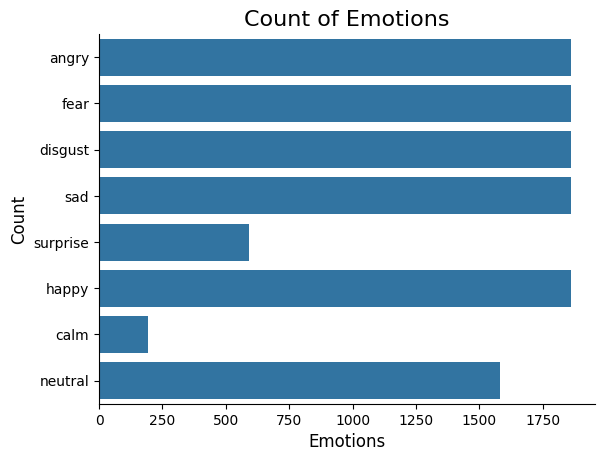

In [68]:
plt.title('Count of Emotions', size=16)
sns.countplot(path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

#### Simple audio

In [64]:
# taking any example and checking for techniques.
path = np.array(path.Path)[1]
data, sample_rate = librosa.load(path)

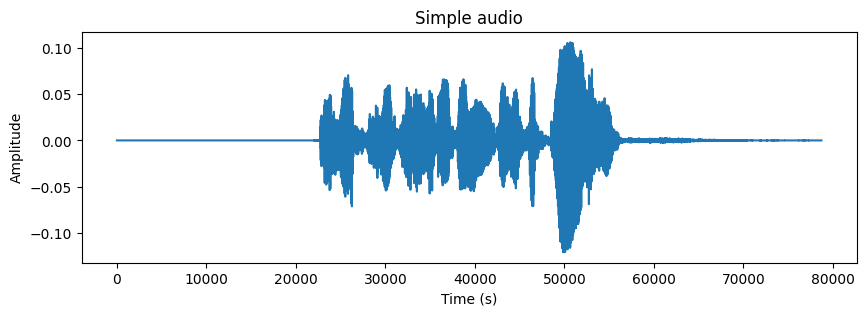

In [65]:
# Plot the waveform using matplotlib
plt.figure(figsize=(10, 3))
plt.plot(data)
plt.title('Simple audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Display audio player
Audio(data, rate=sample_rate)

np.hstack is then used to horizontally concatenate these feature vectors into a single, one-dimensional array (result), which becomes the feature representation for that audio file.

In [13]:
def extract_features(data):
    # ZCR (Zero Crossing Rate)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Energy
    energy = np.mean((librosa.feature.rms(y=data)).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Flux
    spectral_flux = np.mean(librosa.onset.onset_strength(y=data, sr=sample_rate).T, axis=0)

    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)

    # Chroma Vector
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)

    # Stack all features horizontally
    result = np.hstack((zcr, energy, spectral_centroid, spectral_spread, spectral_flux, mfcc, chroma))
    return result

In [14]:

def get_features(path):
    # duration and offset are used to take care of the no audio in start 
    # and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    result = extract_features(data)
    
    return result
    

#### Extract features 

In [15]:
# List of feature names
feature_names = [
    'ZCR', 'Energy', 'SpectralCentroid', 'SpectralSpread', 'SpectralFlux',
    'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
    'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'MFCC13',
    'Chroma1', 'Chroma2', 'Chroma3', 'Chroma4', 'Chroma5', 'Chroma6',
    'Chroma7', 'Chroma8', 'Chroma9', 'Chroma10', 'Chroma11', 'Chroma12'
]


In [19]:
X, Y= [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    X.append(feature)
    Y.append(emotion)

/Users/siakesophie/Local_Docs/ING_3/S9/Engineering_project/project/SERAPP/.env-serapp/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [22]:
len(X), len(Y), data_path.Path.shape

(11682, 11682, (11682,))

### Création du dataset

In [23]:
Features_simple = pd.DataFrame(X, columns=feature_names)
Features_simple['labels'] = Y
Features_simple.to_csv('features_simple.csv', index=False)
Features_simple.head()

,ZCR,Energy,SpectralCentroid,SpectralSpread,SpectralFlux,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,...,Chroma4,Chroma5,Chroma6,Chroma7,Chroma8,Chroma9,Chroma10,Chroma11,Chroma12,labels
0,0.204540,0.018793,3157.236579,2216.501199,2.351883,-440.286591,52.299297,-6.665863,4.278304,-15.808314,...,0.321975,0.346781,0.480067,0.331558,0.274953,0.354453,0.393035,0.393787,0.369280,angry
1,0.189815,0.012744,2744.419931,1984.251392,1.925617,-484.020691,52.436253,-8.613789,6.417563,-3.227553,...,0.285417,0.207637,0.242176,0.227869,0.242703,0.299185,0.388764,0.382405,0.378763,fear
2,0.200589,0.061085,3130.434636,2301.913172,2.341648,-315.505432,27.667685,-38.753201,0.213876,-14.901350,...,0.237158,0.168251,0.235008,0.320012,0.395711,0.443678,0.420142,0.433307,0.439407,fear
3,0.177156,0.040083,2874.637946,2220.399237,2.429970,-346.149780,52.521111,-14.139482,6.766320,-16.968788,...,0.367692,0.330350,0.368875,0.278672,0.218055,0.257016,0.376277,0.342528,0.312693,angry
4,0.175203,0.006512,2897.465696,2159.335761,2.339541,-532.369385,70.741547,-1.425078,11.303340,-9.632647,...,0.345111,0.322321,0.372758,0.350202,0.387294,0.438436,0.350818,0.331767,0.371133,disgust


In [24]:
Features_simple.shape

(11682, 31)

In [16]:
df_features_simple = pd.read_csv('features_simple.csv')
X_simple = df_features_simple.drop(['labels'], axis=1)
Y_simple = df_features_simple['labels']

In [17]:
original_labels = ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the four emotions you want to predict
target_emotions = ['angry', 'fear', 'disgust', 'sad']


In [18]:
df_features_simple.shape

(11682, 31)

In [19]:
# Filter the data to include only the target emotions
filtered_data = df_features_simple[df_features_simple['labels'].isin(target_emotions)]

# Prepare your features and labels
X_simple = filtered_data.drop('labels', axis=1)  # Adjust according to your data
Y_simple = filtered_data['labels']

In [20]:
Y_simple.unique(), Y_simple.shape

(array(['angry', 'fear', 'disgust', 'sad'], dtype=object), (7452,))

In [21]:
Y_simple = np.array(Y_simple)
X_simple = np.array(X_simple)

In [22]:
X_simple.shape, Y_simple.shape

((7452, 30), (7452,))

In [23]:
np.min(X_simple), np.max(X_simple)

(-1131.3707275390625, 4990.732365133476)

#### Data Scaling 

In [24]:
# Reshape X_simple if needed (MinMaxScaler expects 2D array)
X_simple_reshaped = X_simple.reshape(-1, 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X_simple_reshaped)

In [25]:
np.min(X_scaled), np.max(X_scaled)

(0.0, 0.9999999999999999)

#### Data Split

In [26]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_simple, Y_simple, random_state=42, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5961, 30), (5961,), (1491, 30), (1491,))

In [27]:
y_train

array(['disgust', 'fear', 'sad', ..., 'sad', 'fear', 'sad'], dtype=object)

#### Model Training

In [28]:
def cnn_train_model(num_classes, input_features):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_features,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Use 'softmax' for multi-class classification
    
    return model


In [29]:
def evaluate_cnn_model(model, X_test, y_test, label_encoder, target_emotions):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    # Predictions
    y_pred = model.predict(X_test)

    # Decode labels
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Create a DataFrame for easier handling
    df_pred = pd.DataFrame({'Actual': y_test_decoded, 'Predicted': y_pred_decoded})

    # Filter predictions and actual labels for the target emotions
    df_pred_filtered = df_pred[df_pred['Actual'].isin(target_emotions) & df_pred['Predicted'].isin(target_emotions)]

    # Calculate the correct predictions
    df_pred_filtered['Correct'] = df_pred_filtered['Actual'] == df_pred_filtered['Predicted']

    # Print the confusion matrix
    confusion_matrix = pd.crosstab(df_pred_filtered['Actual'], df_pred_filtered['Predicted'],
                                   rownames=['Actual'], colnames=['Predicted'])
    print("Confusion Matrix:")
    print(confusion_matrix)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_pred_filtered['Actual'], df_pred_filtered['Predicted']))

    # Visualize the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_emotions, yticklabels=target_emotions)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



In [30]:
def evaluate_cnn_model_overfitting(loaded_history=None):
    
    if loaded_history:
        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(loaded_history['loss'])
        plt.plot(loaded_history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(loaded_history['accuracy'])
        plt.plot(loaded_history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()


#### Encode labels

In [31]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

#save label encoder
joblib.dump(label_encoder, 'models_SIAKE/label_encoder.pkl')

['models_SIAKE/label_encoder.pkl']

#### CNN Model

In [33]:
input_features = X_train.shape[1]
num_classes = 4

cnn_model = cnn_train_model(num_classes, input_features)

In [34]:
num_epochs = 20
learning_rate = 0.001
batch_size = 35

In [35]:
sgd = keras.optimizers.legacy.SGD(learning_rate = learning_rate)
adam = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
optimizer = keras.optimizers.legacy.Adagrad(learning_rate=learning_rate)

# Compile the model
cnn_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12996 (50.77 KB)
Trainable params: 12740 (49.77 KB)
Non-trainable params: 256 (1.00 KB)
__________________

In [37]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=0)

In [39]:
# Train the model with callbacks
history = cnn_model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size,
                                  validation_split=0.2, verbose=2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
137/137 - 0s - loss: 0.9410 - accuracy: 0.5927 - val_loss: 0.9423 - val_accuracy: 0.6085 - 128ms/epoch - 938us/step
Epoch 2/20
137/137 - 0s - loss: 0.9446 - accuracy: 0.5841 - val_loss: 1.0000 - val_accuracy: 0.5826 - 127ms/epoch - 925us/step
Epoch 3/20
137/137 - 0s - loss: 0.9490 - accuracy: 0.5938 - val_loss: 0.9398 - val_accuracy: 0.5893 - 99ms/epoch - 726us/step
Epoch 4/20
137/137 - 0s - loss: 0.9387 - accuracy: 0.5875 - val_loss: 0.9696 - val_accuracy: 0.5943 - 98ms/epoch - 718us/step
Epoch 5/20
137/137 - 0s - loss: 0.9345 - accuracy: 0.5921 - val_loss: 0.9380 - val_accuracy: 0.6220 - 98ms/epoch - 712us/step
Epoch 6/20
137/137 - 0s - loss: 0.9395 - accuracy: 0.5908 - val_loss: 0.9382 - val_accuracy: 0.6136 - 97ms/epoch - 710us/step
Epoch 7/20
137/137 - 0s - loss: 0.9303 - accuracy: 0.5969 - val_loss: 0.9165 - val_accuracy: 0.6270 - 105ms/epoch - 769us/step
Epoch 8/20
137/137 - 0s - loss: 0.9291 - accuracy: 0.5992 - val_loss: 1.0263 - val_accuracy: 0.5574 - 98ms/epoch - 

In [40]:
# Save the model
cnn_model.save('best_model.h5')

# Save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Test Loss: 0.8956
Test Accuracy: 0.6130
47/47 [==============================] - 0s 349us/step
Confusion Matrix:
Predicted  angry  disgust  fear  sad
Actual                              
angry        306       76    12   13
disgust       42      236     5   74
fear          69      105    94   93
sad            6       70    12  278

Classification Report:
              precision    recall  f1-score   support

       angry       0.72      0.75      0.74       407
     disgust       0.48      0.66      0.56       357
        fear       0.76      0.26      0.39       361
         sad       0.61      0.76      0.67       366

    accuracy                           0.61      1491
   macro avg       0.64      0.61      0.59      1491
weighted avg       0.65      0.61      0.59      1491



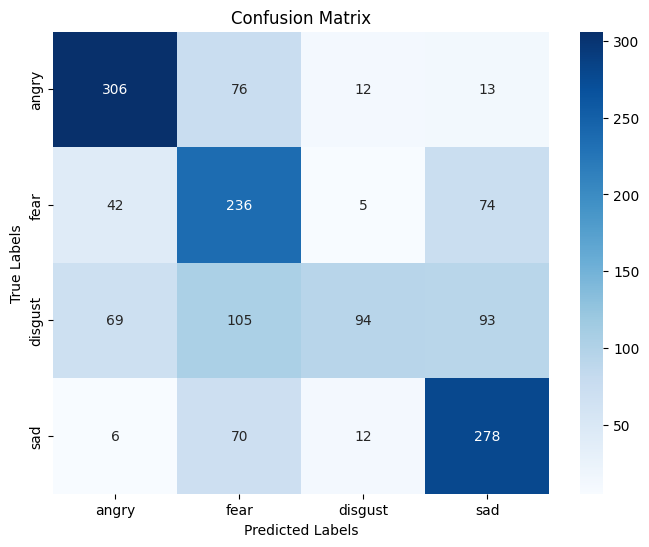

In [41]:
from keras.models import load_model

# Load the model
loaded_model = load_model('best_model.h5')

# Later, to load the label encoder
loaded_label_encoder = joblib.load('models_SIAKE/label_encoder.pkl')

# Assuming you have X_test, y_test, and label_encoder
evaluate_cnn_model(loaded_model, X_test, y_test_encoded, loaded_label_encoder, target_emotions)


In [42]:
# Load the training history
with open('training_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)


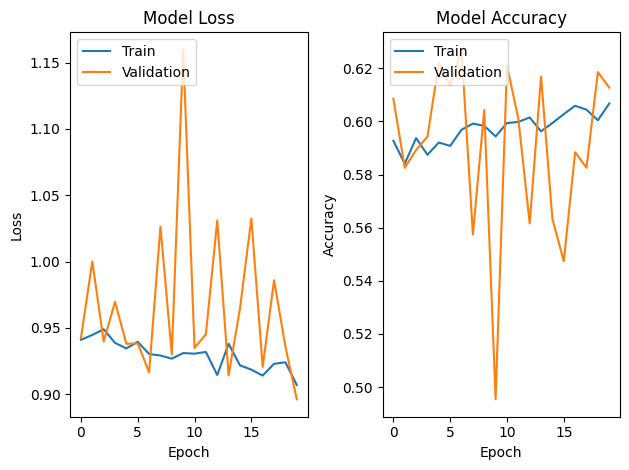

In [43]:
evaluate_cnn_model_overfitting(loaded_history)

### Predictions

In [44]:
# Make predictions
predictions = loaded_model.predict(X_test)

# Get the index of the maximum probability in each prediction
predicted_labels = np.argmax(predictions, axis=1)

# Convert predictions to binary labels
#predicted_labels_binary = np.round(predictions_binary).flatten()

# Decode the predicted labels using the label encoder
predicted_emotions = label_encoder.inverse_transform(predicted_labels)




47/47 [==============================] - 0s 1ms/step


In [45]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = predicted_emotions
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,sad,sad
2,angry,disgust
3,angry,angry
4,disgust,angry
5,disgust,angry
6,sad,sad
7,disgust,sad
8,disgust,sad
9,sad,sad


In [46]:
np.sum(df['Predicted Labels']== df['Actual Labels']), len(df)

(914, 1491)

### Saving models

In [47]:
# Sauvegarde des modeles
print("🔄 Models saving ...")
joblib.dump(loaded_model, 'models_SIAKE/cnn_model.pkl')
print("✅ Models saved successfully !")

🔄 Models saving ...
✅ Models saved successfully !


### Test of models

In [48]:
# Chargement des modeles
loaded_cnn_model = joblib.load('models_SIAKE/cnn_model.pkl')

In [49]:
# Later, to load the label encoder
loaded_label_encoder = joblib.load('models_SIAKE/label_encoder.pkl')

In [50]:
def predict_emotion(model, label_encoder, audio_test_file):
    data, sample_rate = librosa.load(audio_test_file, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1).reshape(1, -1)
    res = scaler.fit_transform(result)
        
    # Make prediction using the provided model
    prediction = model.predict(res)

    # Get the index of the emotion with the highest probability
    max_prob_index = np.argmax(prediction, axis=1)

    # Decode the predicted label using the label encoder
    predicted_emotion = label_encoder.inverse_transform(max_prob_index)

    print("Audio File is anger: ", audio_test_file)
    print("CNN Prediction: ", predicted_emotion)
    
    return predict_emotion


In [52]:
audio_file = "test_data/Savee_audios/DC_sa01.wav"

predicted_emotions = predict_emotion(loaded_model, loaded_label_encoder, audio_file)

1/1 [==============================] - 0s 13ms/step
Audio File is anger:  test_data/Savee_audios/DC_sa01.wav
CNN Prediction:  ['fear']


In [53]:
def get_true_label(file_path):
    label_mapping = {
        'a': 'angry',
        'c': 'calm',
        'd': 'disgust',
        'f': 'fear',
        'h': 'happy',
        'n': 'neutral',
        'sa': 'sad',
        'su': 'surprise'
    }

    # Extract the first letter after the underscore
    file_name = os.path.basename(file_path)
    parts = file_name.split('.')[0]
    part = parts.split('_')[1]
    
    letters = [char.lower() for char in part if char.isalpha()]
    label = ''.join(letters)
    
    # Get the corresponding label from the mapping
    true_label = label_mapping[label]

    return true_label

In [54]:
file_path = "test_data/Savee_audios/DC_a01.wav"
get_true_label(file_path)

'angry'

In [55]:
def predict_emotions_in_directory(model, label_encoder, directory_path):
    audio_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.wav')]
        
    predictions = []
    probabilities = []
    true_emotions = []

    correct_predictions = 0
    incorrect_predictions = 0

    for audio_file in audio_files:
        data, sample_rate = librosa.load(audio_file, duration=2.5, offset=0.6)
        
        # without augmentation
        res1 = extract_features(data)
        result = np.array(res1).reshape(1, -1)
        res = scaler.fit_transform(result)
            
        # Make prediction using the provided model
        prediction = model.predict(res)

        # Get the index of the emotion with the highest probability
        max_prob_index = np.argmax(prediction, axis=1)

        # Decode the predicted label using the label encoder
        predicted_emotion = label_encoder.inverse_transform(max_prob_index)
        
        true_label = get_true_label(audio_file)
        
        # Check if the prediction is correct
        if predicted_emotion == true_label:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

        # Get the probability of the predicted label
        predicted_probability = np.max(prediction)

        predictions.append(predicted_emotion)
        probabilities.append(predicted_probability)
        true_emotions.append(true_label)

    total_predictions = len(audio_files)
    print(f"\nTotal Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Incorrect Predictions: {incorrect_predictions}")
        
    return audio_files, predictions, true_emotions, probabilities 

In [56]:
directory_path = "test_data/Savee_audios"

In [57]:
audio_files, predicted_labels, true_emotions, predicted_probabilities = predict_emotions_in_directory(loaded_cnn_model, loaded_label_encoder, directory_path)

1/1 [==============================] - 0s 12ms/step

Total Predictions: 480
Correct Predictions: 60
Incorrect Predictions: 420


In [58]:
prediction_list = [item[0] for item in predicted_labels]

In [59]:
list_values = list(zip(true_emotions, prediction_list, predicted_probabilities))

In [60]:
df_pred = pd.DataFrame(list_values, columns=['label', 'prediction', 'probability'])
df_pred.head()

,label,prediction,probability
0,sad,fear,0.671101
1,sad,fear,0.671101
2,neutral,fear,0.671101
3,surprise,fear,0.671101
4,neutral,fear,0.671101


In [61]:
# Assuming df_pred is your DataFrame containing predictions
confusion_matrix = pd.crosstab(df_pred['label'], df_pred['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Count the correct predictions for each emotion
correct_predictions = []

for label in confusion_matrix.index:
    try:
        correct_predictions.append(confusion_matrix.loc[label, label])
    except KeyError:
        correct_predictions.append(0)

# Add a new column to your DataFrame for correct predictions
df_pred['correct_predictions'] = np.where(df_pred['label'] == df_pred['prediction'], 1, 0)

# Calculate the total correct predictions for each emotion
total_correct_predictions = df_pred.groupby('label')['correct_predictions'].sum()


In [62]:
total_correct_predictions

label
angry        0
disgust      0
fear        60
happy        0
neutral      0
sad          0
surprise     0
Name: correct_predictions, dtype: int64